# This Notebook analysis the results generated by the Python script "RunMNIST_LargeTest.py" and saved in "LargeTest_results_Euclidean7.dat"

(Note  that "RunMNIST_LargeTest.py" is a heavy experiment that took 4 hours on 48 CPU-cores 2.1 GHz machine)

# 1) Load libraries

In [1]:
import tensorflow as tf
import numpy as np
from scipy import stats
from scipy.optimize import minimize
import csv
from scipy import sparse
import time
from matplotlib import pyplot as plt
import string
import matplotlib.ticker as ticker
import sys
#import mosek
#from mosek.fusion import *
#import cvxpy as cvx
from matplotlib import pyplot as plt
import ot
import pickle
from joblib import Parallel, delayed
import multiprocessing

from conditionalEstimates import *

# 2) Load the results

In [2]:

result_filename = "LargeTest_results_Euclidean7.dat"


def loadData():
        file = open(result_filename,"rb")
        fvals_test=pickle.load(file)
        class_fvals_test=pickle.load(file)
        knn_best_params=pickle.load(file)
        mewn_best_params=pickle.load(file)
        nada_best_params=pickle.load(file)        
        nada_best_params2=pickle.load(file)        
        bert_best_params=pickle.load(file)        
        expN=pickle.load(file)
        TrainSize_list=pickle.load(file)
        TestSize=pickle.load(file)
        Noise_list=pickle.load(file)           
        knns_list=pickle.load(file)
        mewn_alphas_list=pickle.load(file)
        mewn_gammak_list=pickle.load(file)
        mewn_rhok_list=pickle.load(file)
        distType=pickle.load(file)
        doClassify=pickle.load(file)       
        nada_N=pickle.load(file)
        mewn_paramsType=pickle.load(file)
        mewn_N=pickle.load(file)
        bert_N=pickle.load(file)
        all_results=pickle.load(file)        
        file.close()  
        return (fvals_test,class_fvals_test,knn_best_params,mewn_best_params,nada_best_params,nada_best_params2,bert_best_params,expN,TrainSize_list,TestSize,Noise_list,knns_list,mewn_alphas_list,mewn_gammak_list,mewn_rhok_list,distType,doClassify,nada_N,mewn_paramsType,mewn_N,bert_N,all_results)
(fvals_test,class_fvals_test,knn_best_params,mewn_best_params,nada_best_params,nada_best_params2,bert_best_params,expN,TrainSize_list,TestSize,Noise_list,knns_list,mewn_alphas_list,mewn_gammak_list,mewn_rhok_list,distType,doClassify,nada_N,mewn_paramsType,mewn_N,bert_N,all_results)=loadData()


# 2) Print the median of hyper parameter choices for each method

In [3]:

print("Knn best params (N=50,N=100,N=500)")
tmp = np.median(knn_best_params,3).squeeze()
print(tmp[1:])
print("Nadaraja-Watson best params (N=50,N=100,N=500)")
tmp = np.median(nada_best_params,3).squeeze()
print(tmp[1:])
print("Nadaraja-Epanechnikov best params (N=50,N=100,N=500)")
tmp = np.median(nada_best_params2,3).squeeze()
print(tmp[1:])
print("BertEtAl best params (rho,k)x(N=50,N=100,N=500)")
tmp = np.median(bert_best_params,3).squeeze(); tmp[1,:]=np.floor(tmp[1,:]); tmp = tmp[0:2,:]
print(tmp)
print("DRCME best params (rho/gamma,gamma_h_i, alpha)x(N=50,N=100,N=500)")
tmp = np.median(mewn_best_params,3).squeeze()
print(tmp[:,1:])
#print(np.median(mewn_best_params,3).squeeze())


Knn best params (N=50,N=100,N=500)
[3. 4. 4.]
Nadaraja-Watson best params (N=50,N=100,N=500)
[0.0217199  0.01905335 0.01468549]
Nadaraja-Epanechnikov best params (N=50,N=100,N=500)
[0.08688998 0.07833851 0.06772045]
BertEtAl best params (rho,k)x(N=50,N=100,N=500)
[[0.48768988 0.71244552 1.31294564 1.31294564]
 [4.         3.         4.         5.        ]]
DRCME best params (rho/gamma,gamma_h_i, alpha)x(N=50,N=100,N=500)
[[1.25892541e-01 1.25892541e-01 6.30957344e-02]
 [1.25892541e+00 1.25892541e+00 1.58489319e+00]
 [4.39549255e-03 2.41969085e-03 7.56764396e-04]]


# 3) Report accuracy when rounding estimator

In [4]:
#Accuracy when rounding
algN = all_results.shape[0]-1
expClassError = np.zeros((algN,len(Noise_list),len(TrainSize_list)))
expClassErrorCI = np.zeros((algN,len(Noise_list),len(TrainSize_list)))
for k in range(len(Noise_list)):
    for kk in range(len(TrainSize_list)):
        ylabel = all_results[0,k,kk,:,:].squeeze()
        yerror = all_results[1:,k,kk,:,:].squeeze()
        tmp = np.mean((yerror<0.5),2)*100
        expClassError[:,k,kk]=np.mean(tmp,1)
        expClassErrorCI[:,k,kk]=stats.norm.ppf(0.95)*np.sqrt(np.divide(np.var(tmp,1),tmp.shape[1]))
Train_list_plot_indexes = np.arange(1,len(TrainSize_list))
print("Avg. Accuracy (kNN, N-W, N-E, BertEtAl, DRCME)x(N=50,N=100,N=500)")
print(np.round(expClassError[:,:,Train_list_plot_indexes][[0,2,3,4,1],:,:].squeeze()))
print("C.I. radius (kNN, N-W, N-E, BertEtAl, DRCME)x(N=50,N=100,N=500)")
print(np.round(expClassErrorCI[:,:,Train_list_plot_indexes][[0,2,3,4,1],:,:].squeeze()))


Avg. Accuracy (kNN, N-W, N-E, BertEtAl, DRCME)x(N=50,N=100,N=500)
[[24. 33. 60.]
 [30. 38. 65.]
 [26. 32. 50.]
 [29. 41. 67.]
 [36. 46. 71.]]
C.I. radius (kNN, N-W, N-E, BertEtAl, DRCME)x(N=50,N=100,N=500)
[[2. 2. 1.]
 [2. 2. 1.]
 [1. 1. 1.]
 [2. 2. 1.]
 [2. 1. 1.]]


# 4) Report on Probability of exact estimation

In [5]:
#Prob of exact estimation
expClassError = np.zeros((algN,len(Noise_list),len(TrainSize_list)))
expClassErrorCI = np.zeros((algN,len(Noise_list),len(TrainSize_list)))
for k in range(len(Noise_list)):
    for kk in range(len(TrainSize_list)):
        ylabel = all_results[0,k,kk,:,:].squeeze()
        yerror = all_results[1:,k,kk,:,:].squeeze()
        tmp = np.mean((yerror<1e-4),2)*100
        expClassError[:,k,kk]=np.mean(tmp,1)
        expClassErrorCI[:,k,kk]=stats.norm.ppf(0.95)*np.sqrt(np.divide(np.var(tmp,1),tmp.shape[1]))
Train_list_plot_indexes = np.arange(1,len(TrainSize_list))
print("Avg. Exact Estimation Frequency (kNN, N-W, N-E, BertEtAl, DRCME)x(N=50,N=100,N=500)")
print(np.round(expClassError[:,:,Train_list_plot_indexes][[0,2,3,4,1],:,:].squeeze()))
print("C.I. radius (kNN, N-W, N-E, BertEtAl, DRCME)x(N=50,N=100,N=500)")
print(np.round(expClassErrorCI[:,:,Train_list_plot_indexes][[0,2,3,4,1],:,:].squeeze()))


Avg. Exact Estimation Frequency (kNN, N-W, N-E, BertEtAl, DRCME)x(N=50,N=100,N=500)
[[18. 26. 55.]
 [ 2.  3.  8.]
 [13. 18. 30.]
 [23. 33. 60.]
 [30. 39. 66.]]
C.I. radius (kNN, N-W, N-E, BertEtAl, DRCME)x(N=50,N=100,N=500)
[[3. 3. 2.]
 [1. 1. 1.]
 [1. 1. 1.]
 [3. 2. 1.]
 [2. 2. 1.]]


# 5) Graph the CDFs of absolute estimation error

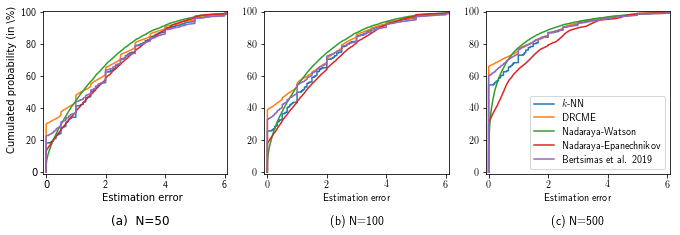

In [6]:
# present whole distributions
Train_list_plot_indexes = np.arange(1,fvals_test.shape[2])
plt.figure(figsize=(3.8*len(TrainSize_list),3*len(Noise_list)))
for k in range(fvals_test.shape[1]):
    for kk in range(len(Train_list_plot_indexes)):
        tmp = all_results[:,k,Train_list_plot_indexes[kk],:,:].reshape(all_results.shape[0],expN*TestSize).squeeze()
        ax = plt.subplot(all_results.shape[1], all_results.shape[2], k*all_results.shape[2]+kk+1)
        plt.ylim(-1, 101); plt.xlim(-0.1,6.1)
        plt.rc('text', usetex=True)
        plt.plot(np.sort(tmp[1,:].squeeze()), np.linspace(0, 100, tmp.shape[1], endpoint=False),label=r'$k$-NN')
        plt.plot(np.sort(tmp[2,:].squeeze()), np.linspace(0, 100, tmp.shape[1], endpoint=False),label='DRCME')
        plt.plot(np.sort(tmp[3,:].squeeze()), np.linspace(0, 100, tmp.shape[1], endpoint=False),label='Nadaraya-Watson')
        plt.plot(np.sort(tmp[4,:].squeeze()), np.linspace(0, 100, tmp.shape[1], endpoint=False),label='Nadaraya-Epanechnikov')
        plt.plot(np.sort(tmp[5,:].squeeze()), np.linspace(0, 100, tmp.shape[1], endpoint=False),label='Bertsimas et al. 2019')
        plt.xlabel(r'Estimation error'); 
        if kk==0:
            plt.ylabel(r'Cumulated probability (in \%)')
        if kk==len(Train_list_plot_indexes)-1:
            ax.legend(loc='lower right')#, bbox_to_anchor=(0.5, 1.05),ncol=1, fancybox=False, shadow=False)
        ax.set_title("("+string.ascii_lowercase[k*all_results.shape[2]+kk]+")  N="+str(int(TrainSize_list[Train_list_plot_indexes[kk]])), y=-0.35)

plt.savefig("errorCDFs.pdf", bbox_inches = "tight", pad_inches = 0)
plt.show()    
plt.close()

# 6) Graph type-p deviation of absolute errors

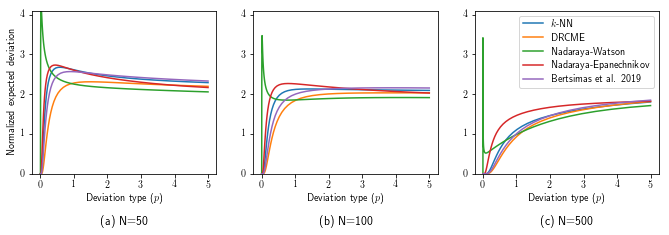

In [7]:


#present error vs Lp norm
xN = 100; algN = all_results.shape[0]-1
Lps = np.logspace(-5, np.log10(5), xN)
Lp_perfs = np.zeros((algN,len(Noise_list),len(TrainSize_list),len(Lps)))
for k in range(len(Lps)):
#    Lp_perfs[:,:,:,k]= np.divide(np.power(np.mean(np.mean(np.power(all_results[1:,:,:,:,:],Lps[k]),4),3),np.divide(1,Lps[k])),np.sqrt(Lps[k]))
    Lp_perfs[:,:,:,k]= np.sqrt(2)*np.divide(np.power(np.mean(np.mean(np.power(all_results[1:,:,:,:,:],Lps[k]),4),3),np.divide(1,Lps[k])),np.sqrt(Lps[k]))
#    Lp_perfs[:,:,:,k]= np.mean(np.divide(np.power(np.mean(np.power(all_results[1:,:,:,:,:],Lps[k]),4),np.divide(1,Lps[k])),np.sqrt(Lps[k])),3)
    
Train_list_plot_indexes = np.arange(1,fvals_test.shape[2])
plt.figure(figsize=(3.8*len(TrainSize_list),3*len(Noise_list)))
for k in range(fvals_test.shape[1]):
    for kk in range(len(Train_list_plot_indexes)):
        tmp = Lp_perfs[:,k,Train_list_plot_indexes[kk],:]
        ax = plt.subplot(all_results.shape[1], all_results.shape[2], k*all_results.shape[2]+kk+1)
        plt.ylim(0, 4.1); #plt.xlim(0,5)
        plt.rc('text', usetex=True)        
        plt.plot(Lps,tmp[0,:].squeeze(),label=r'$k$-NN')#, endpoint=False))
        plt.plot(Lps,tmp[1,:].squeeze(),label='DRCME')#, endpoint=False))
        plt.plot(Lps,tmp[2,:].squeeze(),label='Nadaraya-Watson')#, endpoint=False))
        plt.plot(Lps,tmp[3,:].squeeze(),label='Nadaraya-Epanechnikov')#, endpoint=False))
        plt.plot(Lps,tmp[4,:].squeeze(),label='Bertsimas et al. 2019')
        
        #ax.set_title("(Noise:"+str(Noise_list[k])+", Train size:"+str(TrainSize_list[kk])+")")
        ax.xaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0))
        plt.xlabel(r'Deviation type ($p$)'); 
        if kk==0:
            plt.ylabel(r'Normalized expected deviation')
        if kk==len(Train_list_plot_indexes)-1:
            ax.legend(loc='best')#, bbox_to_anchor=(0.5, 1.05),ncol=1, fancybox=False, shadow=False)
        ax.set_title("("+string.ascii_lowercase[k*all_results.shape[2]+kk]+")  N="+str(int(TrainSize_list[Train_list_plot_indexes[kk]])), y=-0.35)
#        ax.set_title("("+string.ascii_lowercase[k*all_results.shape[2]+kk]+")", y=-0.35)

plt.savefig("typePdeviation.pdf", bbox_inches = "tight", pad_inches = 0)
plt.show()    
plt.close()


# 7) Report Mean square error


In [8]:
# MSE results
tmp = np.power(np.mean(np.mean(np.power(all_results[1:,:,:,:,:],2),4),3),np.divide(1,2)).squeeze()
print("Root Mean Square Error over all tests (kNN, N-W, N-E, BertEtAl, DRCME)x(N=50,N=100,N=500)")
print(tmp[:,Train_list_plot_indexes][[0,2,3,4,1],:])

Root Mean Square Error over all tests (kNN, N-W, N-E, BertEtAl, DRCME)x(N=50,N=100,N=500)
[[2.4604479  2.12534166 1.46197259]
 [2.16218806 1.89055456 1.31919276]
 [2.41447956 2.18241252 1.67030651]
 [2.48537012 2.13049206 1.45994338]
 [2.3002587  2.00636609 1.40490153]]


# Adversarial tests

# 8) Load the MNIST dataset

In [9]:
TrainSizeId = 2;
NoiseSizeId = 0;
TestSize = 10;
TrainSize = TrainSize_list[TrainSizeId]
doCV = False
CEprob = MNIST_ConditionalEstimateProblem(doClassify=doClassify)
CEprob.set_noise(noiseType='Gaussian',noise_sigma=Noise_list[NoiseSizeId])
ImgSize = CEprob.ImgSize

#load data
(x_train2,y_train2,x_test2,y_test2) = CEprob.getDataSet(TrainSize,TestSize,doRandomize=False)
ImgDist = imageDistance(CEprob.ImgSize,distType = distType)
if doCV:
    (x_train2b,x_test2b)=ImgDist.load_hashTableFromData(x_train2,x_test2)
print((TrainSize,Noise_list[NoiseSizeId]))

(100, 0)


# 9) Create the models

In [10]:
model1Type = "nada"
if model1Type == "kNN":
    #prepare average knn predictor
    model1 = kNN_model(ImgDist.getDist,ks_list = knns_list)
    if doCV:
        (knn_best, knn_best_fval, knn_cv_fvals) = crossValidation(model1.getParamsList(),model1.predictor, x_train2b,y_train2,best_type='mean')
        model1.setParams(knn_best); model1.setObs(x_train2b,y_train2)
    else:
        knn_params = np.round(np.median(knn_best_params,3)[:,NoiseSizeId,TrainSizeId])
        model1.setParams(knn_params); model1.setObs(x_train2,y_train2)
elif model1Type == "bert":
    model1 = wassersteinRobust_model(ImgDist.getDist)
    #mewn_params[0] = np.floor(mewn_params[0]); mewn_params[1] = np.round(mewn_params[1]);
    #mewn_params = [0,1,0.00001]
    if doCV:
        model1.setParamsList_Bertsimas(x_train2b,y_train2,mewn_N)        
        (bert_best, bert_best_fval, bert_cv_fvals) = crossValidation(model1.getParamsList(),model1.predictor, x_train2b,y_train2,best_type='mean')
        model1.setParams(bert_best); model1.setObs(x_train2b,y_train2)
    else:
        bert_params = np.median(bert_best_params,3)[:,NoiseSizeId,TrainSizeId]; # mewn_params[2] = 0.0001 
        bert_params[1]=np.floor(bert_params[1])
    #    mewn_params[0:2] = np.round(mewn_params[0:2]);
        model1.setParams(bert_params); model1.setObs(x_train2,y_train2)    
else:
    #prepare N-W predictor
    model1 = nadarajaWatson_model(ImgDist.getDist)
    if doCV:
        model1.setBandwidthList(x_train2b,nada_N)
        (nada_best, tmp1, tmp2) = crossValidation(model1.getParamsList(),model1.predictor, x_train2b,y_train2,best_type='mean')
        model1.setParams(nada_best); model1.setObs(x_train2b,y_train2)
    else:
        nada_params = np.median(nada_best_params,3)[:,NoiseSizeId,TrainSizeId]
        model1.setParams(nada_params); model1.setObs(x_train2,y_train2)
    
    
#prepare average best mewn
mewn = wassersteinRobust_model(ImgDist.getDist,paramsType=mewn_paramsType)
#mewn_params[0] = np.floor(mewn_params[0]); mewn_params[1] = np.round(mewn_params[1]);
#mewn_params = [0,1,0.00001]
if doCV:
    mewn.setParamsListDD2(x_train2b,y_train2,mewn_N)
    (mewn_best, mewn_best_fval, mewn_cv_fvals) = crossValidation(mewn.getParamsList(),mewn.predictor, x_train2b,y_train2,best_type='mean')
    mewn.setParams(mewn_best); mewn.setObs(x_train2b,y_train2)
else:
    mewn_params = np.median(mewn_best_params,3)[:,NoiseSizeId,TrainSizeId]; # mewn_params[2] = 0.0001 
#    mewn_params[0:2] = np.round(mewn_params[0:2]);
    mewn.setParams(mewn_params); mewn.setObs(x_train2,y_train2)
print((model1.getParams(),mewn.getParams()))

#([3], [2, 1, 0.001])

([0.01905335141798714], [0.12589254117941678, 1.2589254117941673, 0.0024196908516636393])


# 10) Create the method that performs adversarial images and tests

In [11]:
def generateImageLabelSequence(nbImage,model1,model2,index_list,x_list,y_list,saveResults=False,filename="adversarialFig.pdf"):
#    plt.figure(figsize=(20*np.divide(nbImage,9), np.divide(20,9)*len(index_list)))
    plt.figure(figsize=(10*np.divide(nbImage,9), np.divide(10,9)*len(index_list)))
    for k in range(len(index_list)):
        index1 = index_list[k][0]
        index2 = index_list[k][1]
        #find the closest image with a different label
        indexes = np.concatenate((np.arange(0,index1),np.arange(index1+1,x_list.shape[1])))
        tmp = ImgDist.getDist(x_list[:,index1],x_list[:,indexes]).flatten()
        indexes = indexes[np.argsort(tmp)]
        indexes = indexes[np.array(~(y_list[0,indexes]==y_list[0,index1])).flatten()]
        index2 = indexes[index2]
        x1 = x_list[:,index1]
        x2 = x_list[:,index2]

        #produce and plot sequence
        thetas = np.divide(np.arange(nbImage+2),nbImage+2-1)
        thetas = thetas[[0]+list(np.arange(2,nbImage))+[nbImage+1]]
        
#        tmp_dists = np.zeros(nbImage)
        tmp_model1 = np.zeros(nbImage)
        tmp_model2 = np.zeros(nbImage)
        for kk in range(nbImage):
                A = []; A.append(np.divide(x1,np.sum(x1)).reshape(ImgSize)); A.append(np.divide(x2,np.sum(x2)).reshape(ImgSize))
                A = np.array(A)
                if thetas[kk]==0:
                    baryCenter=x1
                elif thetas[kk]==1:
                    baryCenter=x2
                else:
                    baryCenter = ot.bregman.convolutional_barycenter2d(A, 0.0005, [1-thetas[kk], thetas[kk]]); 
                    baryCenter = np.matrix(np.divide(baryCenter.reshape(x1.shape),np.max(baryCenter)))
                tmp_model1[kk]=model1.predictor(baryCenter)        
                tmp_model2[kk]=model2.predictor(baryCenter)
#                tmp_dists[kk] = ImgDist.getDist(x1,baryCenter)

                ax = plt.subplot(len(index_list), nbImage, k*nbImage+kk+1)
                plt.imshow(baryCenter.reshape(ImgSize)*255,cmap='gray', vmin=0, vmax=255)
                ax.set_title("("+str(np.round(tmp_model1[kk],1))+", "+str(np.round(tmp_model2[kk],1))+")")
                plt.axis('off')
#    plt.show()
    plt.subplots_adjust(0,0,1,1.18,0,0.2)
    fig = plt.gcf()
    for ax in fig.axes:
#        ax.axis('off')
#        ax.margins(1,1)
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())
    if saveResults:
        plt.savefig(filename, bbox_inches = "tight", pad_inches = 0)
    plt.show()
    plt.close()


# 11) Create the two figures in the paper N-W vs. DRCME

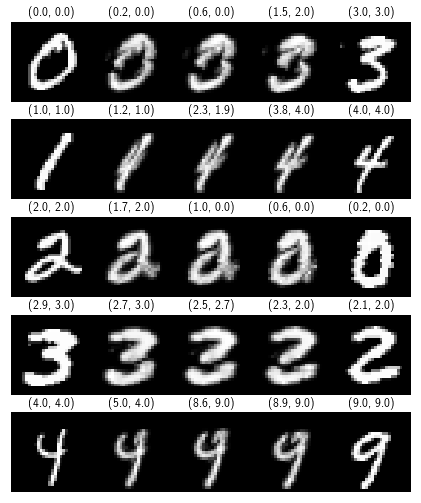

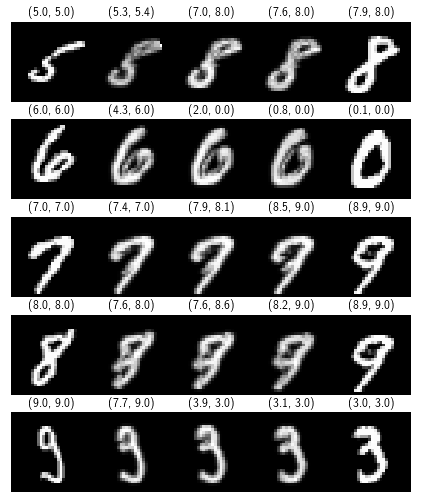

In [12]:
adv_index_list=[[1,0],[3,0],[5,0],[27,0],[26,0]]
generateImageLabelSequence(5,model1,mewn,adv_index_list,x_train2,y_train2,saveResults=True,filename="adversarialFig1.pdf")
adv_index_list=[[11,0],[13,0],[15,0],[17,0],[48,0]]
generateImageLabelSequence(5,model1,mewn,adv_index_list,x_train2,y_train2,saveResults=True,filename="adversarialFig2.pdf")

# 12) Run additional tests N-W vs. DRCME for supplementary material

[0, 4, 6, 9, 10, 12, 16, 18, 19, 21, 22, 24, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49]


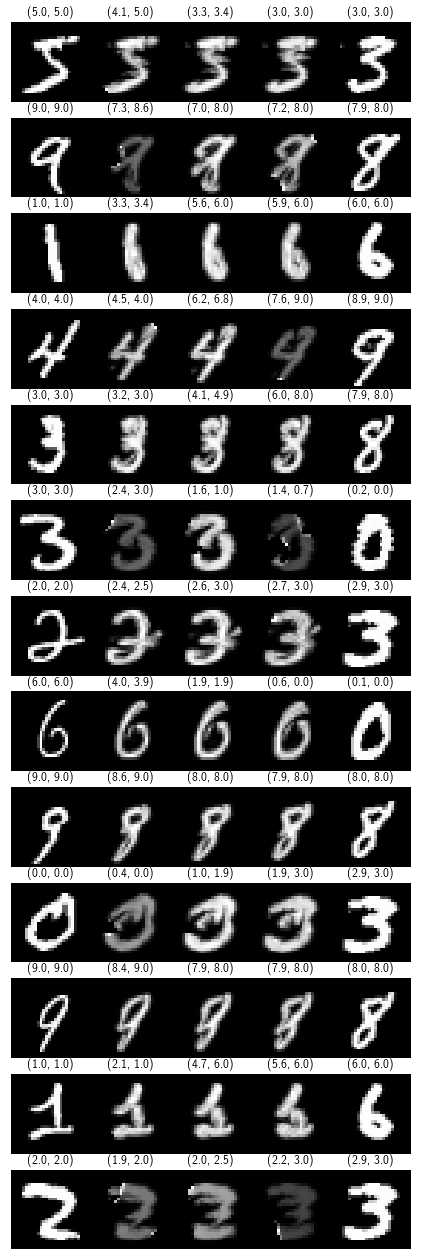

[[0, 0], [4, 0], [6, 0], [9, 0], [10, 0], [12, 0], [16, 0], [18, 0], [19, 0], [21, 0], [22, 0], [24, 0], [28, 0]]
[[29, 0], [30, 0], [31, 0], [32, 0], [33, 0], [34, 0], [35, 0], [36, 0], [38, 0], [39, 0], [40, 0], [41, 0], [42, 0]]


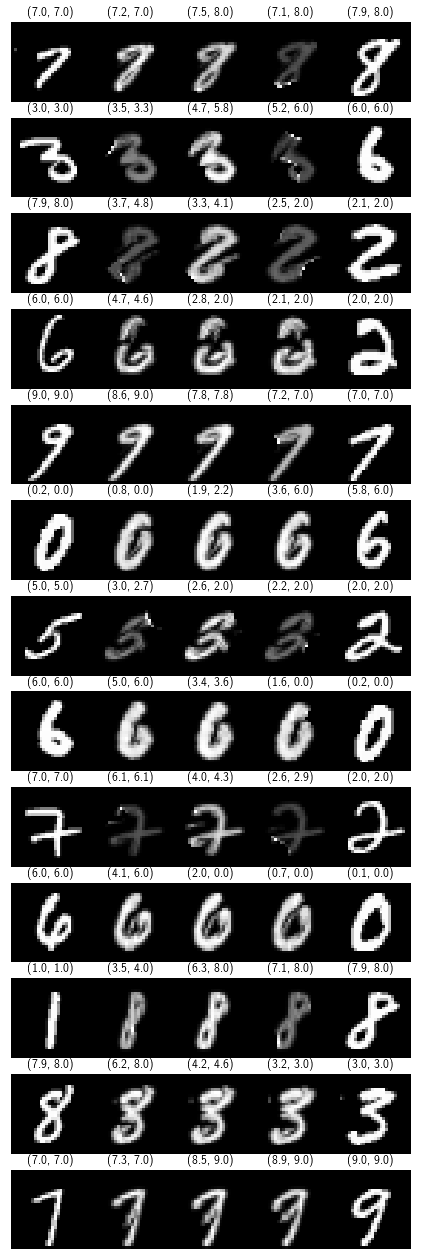

In [13]:
# Additional results
adv_index_list=[[1,0],[3,0],[5,0],[27,0],[26,0],[11,0],[13,0],[15,0],[17,0],[48,0]]
#adv_left_list = [1,3,5,27,26,11,13,15,17,48]
adv_remove_list = [1,3,5,27,26,11,13,15,17,48,2,7,8,14,20,23,25,37] # to avoid repetition of same images
tmp = np.arange(0,50).astype(int)
extra_list = []
for k in range(len(tmp)):
    if not tmp[k]in adv_remove_list:
        extra_list.append(tmp[k])
print(extra_list)
index = 0
while index<len(extra_list):
    tmp = []
    for k in range(13):
        tmp.append([extra_list[index+k],0])
    generateImageLabelSequence(5,model1,mewn,tmp,x_train2,y_train2,saveResults=True,filename="adversarialFigExtra"+str(index)+".pdf")
    print(tmp)
    index = index+13
    tmp = []
    for k in range(13):
        tmp.append([extra_list[index+k],0])
    print(tmp)
    generateImageLabelSequence(5,model1,mewn,tmp,x_train2,y_train2,saveResults=True,filename="adversarialFigExtra"+str(index)+".pdf")
    index = index+13
    
    index=len(extra_list)

# 13) Run additional tests BertEtAl vs. DRCME for supplementary material

[0, 4, 6, 9, 10, 12, 16, 18, 19, 21, 22, 24, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49]


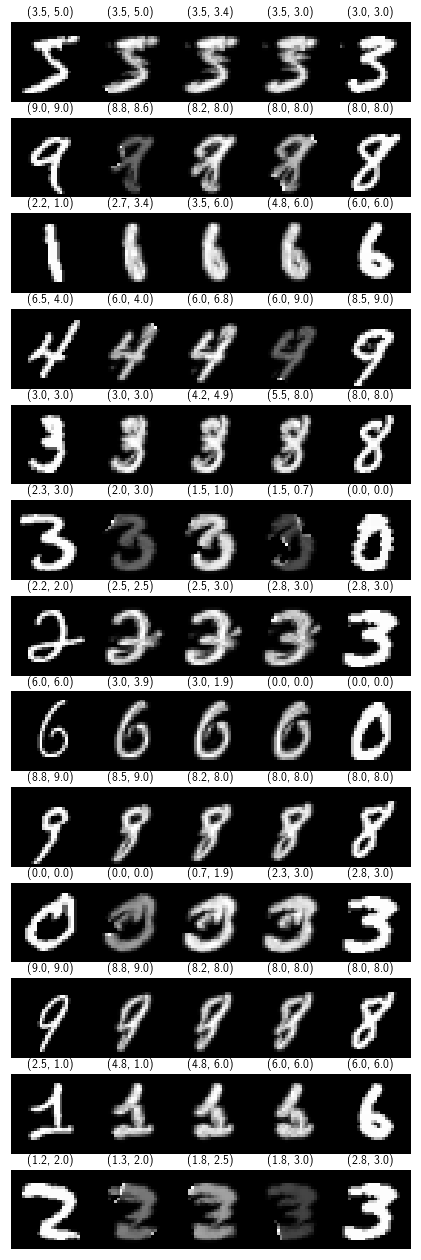

[[0, 0], [4, 0], [6, 0], [9, 0], [10, 0], [12, 0], [16, 0], [18, 0], [19, 0], [21, 0], [22, 0], [24, 0], [28, 0]]
[[29, 0], [30, 0], [31, 0], [32, 0], [33, 0], [34, 0], [35, 0], [36, 0], [38, 0], [39, 0], [40, 0], [41, 0], [42, 0]]


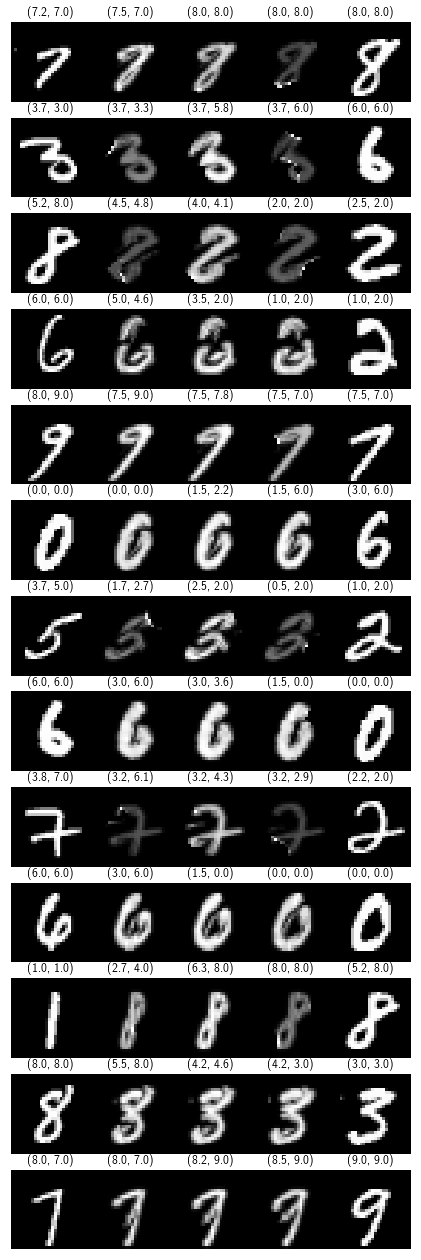

In [14]:
model1 = wassersteinRobust_model(ImgDist.getDist)
bert_params = np.median(bert_best_params,3)[:,NoiseSizeId,TrainSizeId]; # mewn_params[2] = 0.0001 
bert_params[1]=np.floor(bert_params[1])
model1.setParams(bert_params); model1.setObs(x_train2,y_train2)    

# Additional results
tmp = np.arange(0,50).astype(int)
extra_list = []
for k in range(len(tmp)):
    if not tmp[k]in adv_remove_list:
        extra_list.append(tmp[k])
print(extra_list)
index = 0
while index<len(extra_list):
    tmp = []
    for k in range(13):
        tmp.append([extra_list[index+k],0])
    generateImageLabelSequence(5,model1,mewn,tmp,x_train2,y_train2,saveResults=True,filename="adversarialFigExtraBert"+str(index)+".pdf")
    print(tmp)
    index = index+13
    tmp = []
    for k in range(13):
        tmp.append([extra_list[index+k],0])
    print(tmp)
    generateImageLabelSequence(5,model1,mewn,tmp,x_train2,y_train2,saveResults=True,filename="adversarialFigExtraBert"+str(index)+".pdf")
    index = index+13
    
    index=len(extra_list)